In [709]:
import math
import numpy as np
import torch
from torch import nn
import gpytorch
import matplotlib.pylab as plt
from pylightcurve_torch import TransitModule

# A regression toy example
adapted example from GPytorch tutorial https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html


In [710]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 200).double().detach()  # Time vector

In [711]:
# Transit model

pars =  {'e':0.01, 'i':90., 'w':0., 'rp': 0.1, 'method': 'linear', 'ldc': [0.1], 
             'P': 4., 't0': 0.6, 'a': 7., 'fp': 0.0001}
tm = TransitModule(train_x, **pars)

In [712]:

# True function is sin(2*pi*x) with Gaussian noise
train_y = 1. + (torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.01)) / 100
train_y *= tm()[0]
preprocess = lambda y: (y-1.) * 10
train_y = preprocess(train_y)
train_y.double().detach_()
pass

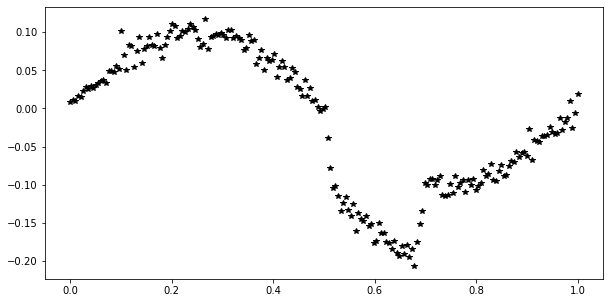

In [713]:
plt.subplots(1, 1, figsize=(10, 5))
plt.plot(train_x, train_y.detach(), 'k*')
#plt.plot(train_x, tm()[0].detach())

# Exact inference

## Transit params as standard modul parameters 
No uncertainty/noise derived for the fitted transit pars

In [714]:
tm.set_params(**pars)
tm.set_params(rp=0.001) #, t0=0.55)
tm.activate_grad('rp') #, 't0')

#tm.deactivate_grad('rp')

In [715]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, tm):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transit_module = tm  ### 
        self.transit_module.set_time(train_x)  ###

    def forward(self, x):
        self.transit_module.set_time(x.flatten()) ###
        mean_x = preprocess(self.mean_module(x) * self.transit_module()[0]) ###
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [716]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().double()
model = ExactGPModel(train_x, train_y, likelihood, tm).double()

In [720]:
training_iter = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': list(model.mean_module.parameters()) 
           + list(model.covar_module.parameters())
           + list(model.likelihood.parameters())},
    {'params': list(model.transit_module.parameters()), 'lr':0.01},  #### different LR for transit par
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.5f  rp: %.5f  t0: %.5f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        model.transit_module.rp.item(),
        model.transit_module.t0.item()
    ))
    optimizer.step()

Iter 1/200 - Loss: 1.288   lengthscale: 0.693   noise: 0.69325  rp: 0.00100  t0: 0.60000
Iter 2/200 - Loss: 1.117   lengthscale: 0.744   noise: 0.64450  rp: 0.00100  t0: 0.60000
Iter 3/200 - Loss: 0.975   lengthscale: 0.797   noise: 0.59820  rp: 0.00844  t0: 0.60000
Iter 4/200 - Loss: 0.856   lengthscale: 0.850   noise: 0.55433  rp: 0.01515  t0: 0.60000
Iter 5/200 - Loss: 0.757   lengthscale: 0.903   noise: 0.51284  rp: 0.02251  t0: 0.60000
Iter 6/200 - Loss: 0.672   lengthscale: 0.955   noise: 0.47369  rp: 0.03027  t0: 0.60000
Iter 7/200 - Loss: 0.598   lengthscale: 1.005   noise: 0.43684  rp: 0.03836  t0: 0.60000
Iter 8/200 - Loss: 0.533   lengthscale: 1.053   noise: 0.40223  rp: 0.04677  t0: 0.60000
Iter 9/200 - Loss: 0.475   lengthscale: 1.098   noise: 0.36980  rp: 0.05547  t0: 0.60000
Iter 10/200 - Loss: 0.422   lengthscale: 1.141   noise: 0.33948  rp: 0.06446  t0: 0.60000
Iter 11/200 - Loss: 0.372   lengthscale: 1.180   noise: 0.31120  rp: 0.07375  t0: 0.60000
Iter 12/200 - Loss:

Iter 106/200 - Loss: -3.013   lengthscale: 0.546   noise: 0.00017  rp: 0.10125  t0: 0.60000
Iter 107/200 - Loss: -3.017   lengthscale: 0.538   noise: 0.00017  rp: 0.09983  t0: 0.60000
Iter 108/200 - Loss: -3.020   lengthscale: 0.530   noise: 0.00016  rp: 0.09920  t0: 0.60000
Iter 109/200 - Loss: -3.023   lengthscale: 0.524   noise: 0.00016  rp: 0.10043  t0: 0.60000
Iter 110/200 - Loss: -3.026   lengthscale: 0.520   noise: 0.00016  rp: 0.10016  t0: 0.60000
Iter 111/200 - Loss: -3.028   lengthscale: 0.518   noise: 0.00016  rp: 0.09901  t0: 0.60000
Iter 112/200 - Loss: -3.031   lengthscale: 0.517   noise: 0.00016  rp: 0.09972  t0: 0.60000
Iter 113/200 - Loss: -3.033   lengthscale: 0.517   noise: 0.00015  rp: 0.10037  t0: 0.60000
Iter 114/200 - Loss: -3.036   lengthscale: 0.520   noise: 0.00015  rp: 0.09935  t0: 0.60000
Iter 115/200 - Loss: -3.038   lengthscale: 0.523   noise: 0.00015  rp: 0.09943  t0: 0.60000
Iter 116/200 - Loss: -3.040   lengthscale: 0.526   noise: 0.00015  rp: 0.10042  

In [721]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).double()
    observed_pred = likelihood(model(test_x))

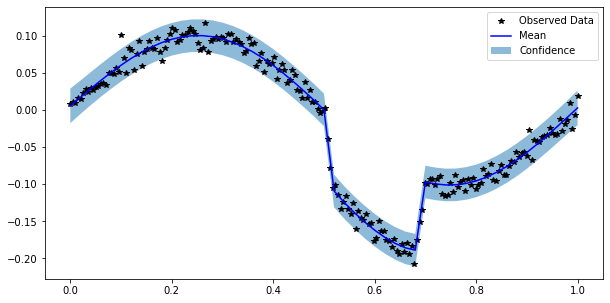

In [722]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## Sampling in fully bayesian mode

In [687]:
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC
from matplotlib import pyplot as plt

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
import os
os.environ["OMP_NUM_THREADS"] = '1'


In [688]:
from gpytorch.means.mean import Mean

class TransitMean(TransitModule, Mean):
    def __init__(self, time=None, primary=True, secondary=False, epoch_type=None, precision=3, dtype=torch.float64,
                 cache_pos=False, cache_flux=False, cache_dur=False, **kwargs):
        super().__init__(time, primary, secondary, epoch_type, precision, dtype, cache_pos, cache_flux, cache_dur,
                         **kwargs)

tm = TransitMean()

In [689]:
tm.set_params(**pars)
tm.set_params(rp=0.001)
tm.activate_grad('rp')


In [690]:
tm.rp

Parameter containing:
tensor([[0.0010]], dtype=torch.float64, requires_grad=True)

In [691]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, tm):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.transit_mean = tm  ### 
        self.transit_mean.set_time(train_x)  ###

    def forward(self, x):
        if x.shape[-1] == 1:
            self.transit_mean.set_time(x.squeeze(-1))
        else:
            self.transit_mean.set_time(x) ###
        #print('x shape', x.shape)
        mean_x = self.mean_module(x) 
        #print('mean_x shape', mean_x.shape)
        drop_flux = self.transit_mean.forward().view_as(mean_x) ###
        mean_x = preprocess(mean_x * drop_flux)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [692]:


from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
likelihood.double() ###
model = ExactGPModel(train_x, train_y, likelihood, tm)
model.double()  ###



ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (transit_mean): TransitModule(primary=True, shape=(1, 200))
)

In [693]:
training_iter = 400

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': list(model.mean_module.parameters()) 
           + list(model.covar_module.parameters())
           + list(model.likelihood.parameters())},
    {'params': list(model.transit_mean.parameters()), 'lr':0.01},  #### different LR for transit par
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.5f  rp: %.5f  t0: %.5f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        model.transit_mean.rp.item(),
        model.transit_mean.t0.item()
    ))
    optimizer.step()

Iter 1/400 - Loss: 1.288   lengthscale: 0.693   noise: 0.69315  rp: 0.00100  t0: 0.60000
Iter 2/400 - Loss: 1.117   lengthscale: 0.744   noise: 0.64440  rp: 0.00100  t0: 0.60000
Iter 3/400 - Loss: 0.974   lengthscale: 0.797   noise: 0.59810  rp: 0.00844  t0: 0.60000
Iter 4/400 - Loss: 0.856   lengthscale: 0.850   noise: 0.55423  rp: 0.01515  t0: 0.60000
Iter 5/400 - Loss: 0.756   lengthscale: 0.903   noise: 0.51274  rp: 0.02251  t0: 0.60000
Iter 6/400 - Loss: 0.671   lengthscale: 0.955   noise: 0.47359  rp: 0.03028  t0: 0.60000
Iter 7/400 - Loss: 0.598   lengthscale: 1.005   noise: 0.43674  rp: 0.03837  t0: 0.60000
Iter 8/400 - Loss: 0.533   lengthscale: 1.053   noise: 0.40213  rp: 0.04677  t0: 0.60000
Iter 9/400 - Loss: 0.475   lengthscale: 1.098   noise: 0.36970  rp: 0.05548  t0: 0.60000
Iter 10/400 - Loss: 0.421   lengthscale: 1.141   noise: 0.33938  rp: 0.06448  t0: 0.60000
Iter 11/400 - Loss: 0.372   lengthscale: 1.180   noise: 0.31110  rp: 0.07377  t0: 0.60000
Iter 12/400 - Loss:

Iter 104/400 - Loss: -3.015   lengthscale: 0.548   noise: 0.00009  rp: 0.09822  t0: 0.60000
Iter 105/400 - Loss: -3.014   lengthscale: 0.539   noise: 0.00008  rp: 0.09996  t0: 0.60000
Iter 106/400 - Loss: -3.014   lengthscale: 0.532   noise: 0.00008  rp: 0.09929  t0: 0.60000
Iter 107/400 - Loss: -3.012   lengthscale: 0.526   noise: 0.00008  rp: 0.09787  t0: 0.60000
Iter 108/400 - Loss: -3.014   lengthscale: 0.522   noise: 0.00008  rp: 0.09883  t0: 0.60000
Iter 109/400 - Loss: -3.014   lengthscale: 0.520   noise: 0.00008  rp: 0.09949  t0: 0.60000
Iter 110/400 - Loss: -3.016   lengthscale: 0.520   noise: 0.00009  rp: 0.09810  t0: 0.60000
Iter 111/400 - Loss: -3.017   lengthscale: 0.521   noise: 0.00009  rp: 0.09783  t0: 0.60000
Iter 112/400 - Loss: -3.018   lengthscale: 0.524   noise: 0.00009  rp: 0.09894  t0: 0.60000
Iter 113/400 - Loss: -3.020   lengthscale: 0.528   noise: 0.00009  rp: 0.09864  t0: 0.60000
Iter 114/400 - Loss: -3.022   lengthscale: 0.532   noise: 0.00009  rp: 0.09759  

Iter 207/400 - Loss: -3.037   lengthscale: 0.514   noise: 0.00011  rp: 0.09822  t0: 0.60000
Iter 208/400 - Loss: -3.037   lengthscale: 0.513   noise: 0.00011  rp: 0.09822  t0: 0.60000
Iter 209/400 - Loss: -3.037   lengthscale: 0.512   noise: 0.00011  rp: 0.09822  t0: 0.60000
Iter 210/400 - Loss: -3.037   lengthscale: 0.512   noise: 0.00011  rp: 0.09821  t0: 0.60000
Iter 211/400 - Loss: -3.037   lengthscale: 0.511   noise: 0.00011  rp: 0.09821  t0: 0.60000
Iter 212/400 - Loss: -3.037   lengthscale: 0.510   noise: 0.00011  rp: 0.09821  t0: 0.60000
Iter 213/400 - Loss: -3.038   lengthscale: 0.510   noise: 0.00011  rp: 0.09821  t0: 0.60000
Iter 214/400 - Loss: -3.038   lengthscale: 0.509   noise: 0.00011  rp: 0.09820  t0: 0.60000
Iter 215/400 - Loss: -3.038   lengthscale: 0.508   noise: 0.00011  rp: 0.09820  t0: 0.60000
Iter 216/400 - Loss: -3.038   lengthscale: 0.508   noise: 0.00011  rp: 0.09820  t0: 0.60000
Iter 217/400 - Loss: -3.038   lengthscale: 0.507   noise: 0.00011  rp: 0.09819  

Iter 312/400 - Loss: -3.055   lengthscale: 0.416   noise: 0.00011  rp: 0.09780  t0: 0.60000
Iter 313/400 - Loss: -3.055   lengthscale: 0.415   noise: 0.00011  rp: 0.09779  t0: 0.60000
Iter 314/400 - Loss: -3.055   lengthscale: 0.414   noise: 0.00011  rp: 0.09779  t0: 0.60000
Iter 315/400 - Loss: -3.055   lengthscale: 0.413   noise: 0.00011  rp: 0.09778  t0: 0.60000
Iter 316/400 - Loss: -3.056   lengthscale: 0.412   noise: 0.00011  rp: 0.09778  t0: 0.60000
Iter 317/400 - Loss: -3.056   lengthscale: 0.411   noise: 0.00011  rp: 0.09777  t0: 0.60000
Iter 318/400 - Loss: -3.056   lengthscale: 0.410   noise: 0.00011  rp: 0.09777  t0: 0.60000
Iter 319/400 - Loss: -3.056   lengthscale: 0.409   noise: 0.00011  rp: 0.09776  t0: 0.60000
Iter 320/400 - Loss: -3.056   lengthscale: 0.408   noise: 0.00011  rp: 0.09775  t0: 0.60000
Iter 321/400 - Loss: -3.056   lengthscale: 0.407   noise: 0.00011  rp: 0.09775  t0: 0.60000
Iter 322/400 - Loss: -3.056   lengthscale: 0.406   noise: 0.00011  rp: 0.09774  

In [694]:
model.transit_mean.register_prior("rp_prior", UniformPrior(0., 0.2), "rp")  #####
model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.001, 2.), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.05, 0.3), "noise")

In [695]:
from pyro.infer.mcmc import NUTS, MCMC
num_samples = 300
warmup_steps = 300
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    model.pyro_sample_from_prior()
    output = model(x)
    loss = mll.pyro_factor(output, y)
    return y

nuts_kernel = NUTS(pyro_model, adapt_step_size=True, max_tree_depth=2)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
mcmc_run.run(train_x, train_y)

Sample: 100%|██████████| 600/600 [00:19, 31.53it/s, step size=6.62e-01, acc. prob=0.767]


In [696]:
tm.rp.shape

torch.Size([1, 1])

In [697]:
model.pyro_load_from_samples(mcmc_run.get_samples())

In [698]:
tm.time.shape, tm.rp.shape

(torch.Size([1, 200]), torch.Size([300, 1, 1]))

In [699]:
model.transit_mean.rp.data = model.transit_mean.rp.squeeze(-1)

In [703]:
tm.rp

Parameter containing:
tensor([[3.1879e-02],
        [1.7663e-01],
        [7.8853e-02],
        [1.5317e-01],
        [1.9625e-01],
        [1.8676e-01],
        [8.8913e-02],
        [4.7766e-02],
        [1.6444e-01],
        [8.1270e-02],
        [1.2973e-02],
        [1.4611e-01],
        [1.8232e-02],
        [7.4124e-03],
        [1.9584e-01],
        [1.9655e-01],
        [1.9943e-01],
        [1.8663e-01],
        [3.0733e-02],
        [4.9239e-02],
        [5.7300e-02],
        [7.9042e-02],
        [6.3993e-03],
        [1.2070e-01],
        [1.5012e-01],
        [8.4089e-02],
        [1.3318e-02],
        [5.2855e-03],
        [2.8875e-02],
        [1.3038e-01],
        [1.2214e-01],
        [9.4673e-02],
        [1.8219e-01],
        [1.8219e-01],
        [9.4930e-02],
        [3.0599e-02],
        [7.9214e-02],
        [1.2446e-01],
        [1.8254e-02],
        [1.1190e-01],
        [1.9504e-01],
        [1.5657e-01],
        [1.2713e-01],
        [8.3549e-02],
        [3

In [701]:
model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1).double()
#test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(num_samples, 1, 1)
print(expanded_test_x.shape)
output = model(expanded_test_x)

torch.Size([300, 101, 1])


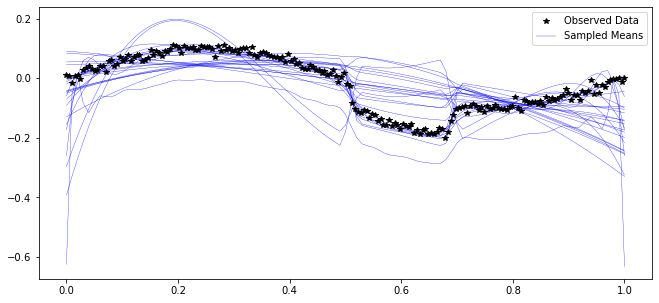

In [702]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(11, 5))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)

    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])




# Beyond exact inference...
* GPyTorch designed for approximate/deep inference. 
* Can perfectly parameterise the mean/cov function with NN